In [1]:
import pandas as pd
from FNFTpy import nsev
import numpy as np
import random
import time
from scipy.fft import fft, ifft, fftfreq, fftshift

import signal_generation as sg
import ssfm
from importlib import reload
reload(sg)
reload(ssfm)


import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import os
import csv

if not os.path.exists("images_nft_examples"):
    os.mkdir("images_nft_examples")

print('done')

done


Here we will generate signal and compute NFT for nice pictures

In [2]:
def gen_and_calc(num_symbols, n_symb, t_symb, n_lateral, p_ave, roll_off, calc_type, mod_type, n_car, seed=0):
    dt = t_symb / n_symb

    print("N symbols:", num_symbols)

    n_bits = n_car * sg.get_n_bits(mod_type) * num_symbols
    random.seed(seed)
    bits = random.getrandbits(n_bits)
    data = "{0:b}".format(int(bits))
    if len(data) < n_bits:
        data = ''.join('0' for add_bit in range(n_bits - len(data))) + data

    signal = sg.get_wdm_signal(data, t_symb, n_symb, sg.rcos, [t_symb, roll_off],
                               n_carriers=n_car, mod_type=mod_type, n_lateral=n_lateral)
    signal = sg.set_average_power(signal, dt, p_ave, n_symb * (num_symbols // 2 - 1))

    # next_2_pow = sg.next_power_of_2(len(signal))
    # signal = sg.add_lateral(signal, (next_2_pow - len(signal)) // 2)

    t = np.array([i * dt for i in range(len(signal))])

    n_signal = len(signal)
    xi_span = np.pi / (2. * dt) * 2
    dxi = xi_span / n_signal
    xi = np.linspace(-xi_span / 2. + dxi, xi_span / 2., n_signal)

    bsl = 2
    if calc_type == 1 or calc_type >= 22:
        bsl = 1

    start = time.time()
    res = nsev(signal, t, M=n_signal, Xi1=xi[0], Xi2=xi[-1], bsl=bsl, dis=calc_type, kappa=1)

    ft_spec = fftshift(fft(signal))[::-1] * dt
    ft_f = fftshift(fftfreq(n_signal, d=dt))[::-1]

    end = time.time()
    print("Elapsed for fnft = %s" % (end - start))

    # propagation
    t_span = t[-1] - t[0]
    z_prop = 95.0
    dz_prop = 2**(-4)
    n_z = (int)(z_prop / dz_prop)
    beta2 = -1.0
    gamma = 1.0
    signal_prop = ssfm.fiber_propogate(signal, t_span, z_prop, n_z, gamma=gamma, beta2=beta2)
    res_prop = nsev(signal_prop, t, M=n_signal, Xi1=xi[0], Xi2=xi[-1], bsl=bsl, dis=calc_type, kappa=1)
    ft_spec_prop = fftshift(fft(signal_prop))[::-1] * dt

    end = time.time()
    # print("Calc type ", calc_type)
    print("Elapsed total = %s" % (end - start))

    return_dict = {"signal": signal, "t": t, "res": res, "xi": xi,
                   "ft_spec": ft_spec, "ft_f": ft_f,
                   "signal_prop": signal_prop, "res_prop": res_prop,
                   "ft_spec_prop": ft_spec_prop,
                   "time": (end - start)}

    return return_dict

In [3]:
mod_type = "16qam"
n_car = 1
t_symb = 1.

p_nd = []
for p_dbm in [-20, -10, -5, 0, 1, 3]:
    # print(mw_to_nd(dbm_to_mw(p_dbm)))
    nd_temp = sg.mw_to_nd(sg.dbm_to_mw(p_dbm), t_symb=14.8)
    p_nd.append(round(nd_temp, 6))

print("Power levels:", p_nd)

Power levels: [0.000129, 0.001294, 0.004092, 0.012939, 0.016289, 0.025816]


In [4]:
time_start = time.time()

df = pd.DataFrame()
# for num_symbols in [64, 256, 512, 1024, 2048, 4096, 8096]:
for num_symbols in [2048, 4096, 8096]:
# for num_symbols in [256]:
    for n_symb in [4, 8, 16, 32]:
        # if n_symb * num_symbols > 2**15:
        #     continue
        n_lat_range = [512 * n_symb]
        # if num_symbols == 1024:
        #     n_lat_range = [1024 * n_symb]
        for n_lateral in n_lat_range:
            for p_ave in p_nd:
                for roll_off in [0.1]:
                    for calc_type in [11]:
                        calc_dict = gen_and_calc(num_symbols=num_symbols,
                                                 n_symb=n_symb,
                                                 t_symb=t_symb,
                                                 n_lateral=n_lateral,
                                                 p_ave=p_ave,
                                                 roll_off=roll_off,
                                                 calc_type=calc_type,
                                                 mod_type=mod_type,
                                                 n_car=n_car)

                        # save results
                        result_dict = {'num_symbols': num_symbols,
                                       'n_symb': n_symb,
                                       't_symb': t_symb,
                                       'n_lateral': n_lateral,
                                       'p_ave': p_ave,
                                       'roll_off': roll_off,
                                       'calc_type': calc_type,
                                       'mod_type': mod_type,
                                       'n_car': n_car,
                                       "signal": calc_dict["signal"],
                                       "t": calc_dict["t"],
                                       "result": calc_dict["res"],
                                       "xi": calc_dict["xi"],
                                       "ft_spec": calc_dict["ft_spec"],
                                       "ft_f": calc_dict["ft_f"],
                                       "signal_prop": calc_dict["signal_prop"],
                                       "res_prop": calc_dict["res_prop"],
                                       "ft_spec_prop": calc_dict["ft_spec_prop"],
                                       "calc_time": calc_dict["time"]
                                       }
                        df = df.append(result_dict, ignore_index=True)
                        df.to_pickle("nft_signal_examples_results_big.pkl")

time_end = time.time()
print("Time :", time_end - time_start, "s")

N symbols: 2048
Elapsed for fnft = 3.063490629196167
Elapsed total = 32.7028865814209
N symbols: 2048
Elapsed for fnft = 4.555621862411499
Elapsed total = 35.75344252586365
N symbols: 2048
Elapsed for fnft = 5.850819826126099
Elapsed total = 38.87448740005493
N symbols: 2048
Elapsed for fnft = 6.809500217437744
Elapsed total = 40.097187519073486
N symbols: 2048
Elapsed for fnft = 6.797503232955933
Elapsed total = 40.20407700538635
N symbols: 2048
Elapsed for fnft = 6.722539186477661
Elapsed total = 42.77478289604187
N symbols: 2048
Elapsed for fnft = 6.123177766799927
Elapsed total = 64.95940256118774
N symbols: 2048
Elapsed for fnft = 10.277208089828491
Elapsed total = 73.2207190990448
N symbols: 2048
Elapsed for fnft = 11.671135902404785
Elapsed total = 76.2924656867981
N symbols: 2048
Elapsed for fnft = 12.830090999603271
Elapsed total = 76.33211135864258
N symbols: 2048
Elapsed for fnft = 12.748489141464233
Elapsed total = 76.37067866325378
N symbols: 2048
Elapsed for fnft = 11.469

In [49]:
df.to_pickle("nft_signal_examples_results_back_new.pkl")
# df.to_pickle("nft_signal_examples_results_back.pkl")

In [30]:
df.head()
print(df)

      calc_time  calc_type                                               ft_f  \
0     27.098710       11.0  [15.996875000000001, 15.99375, 15.990625000000...   
1     27.453879       11.0  [15.996875000000001, 15.99375, 15.990625000000...   
2     26.894972       11.0  [15.996875000000001, 15.99375, 15.990625000000...   
3     27.243968       11.0  [15.996875000000001, 15.99375, 15.990625000000...   
4     28.046748       11.0  [15.996875000000001, 15.99375, 15.990625000000...   
5     27.472470       11.0  [15.996875000000001, 15.99375, 15.990625000000...   
6     43.822102       11.0  [15.998046875, 15.99609375, 15.994140625, 15.9...   
7     43.676259       11.0  [15.998046875, 15.99609375, 15.994140625, 15.9...   
8     45.474242       11.0  [15.998046875, 15.99609375, 15.994140625, 15.9...   
9     49.227987       11.0  [15.998046875, 15.99609375, 15.994140625, 15.9...   
10    54.644938       11.0  [15.998046875, 15.99609375, 15.994140625, 15.9...   
11    53.219944       11.0  

## Load data

In [131]:
df = pd.read_pickle("nft_signal_examples_results.pkl")

In [63]:
print(p_nd[0])



# print(p_nd)
df_one = df[(df.num_symbols == 1024) & (df.p_ave == p_nd[0]) & (df.n_lateral == 512 * 32)]
# print(df_one)
# print(df_one.signal.item())

plt_signal = df_one.signal.item()
plt_ft_spectrum = df_one.ft_spec.item()
plt_nft_spectrum = df_one.result.item()['cont_ref']
plt_t = df_one.t.item()
plt_f = df_one.ft_f.item()
plt_xi = df_one.xi.item()
plt_dt = plt_t[1] - plt_t[0]

plt_signal_prop = df_one.signal_prop.item()
plt_ft_spectrum_prop = df_one.ft_spec_prop.item()
plt_nft_spectrum_prop = df_one.res_prop.item()['cont_ref']

0.000129


<ipython-input-55-a94378a9cbe0>:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



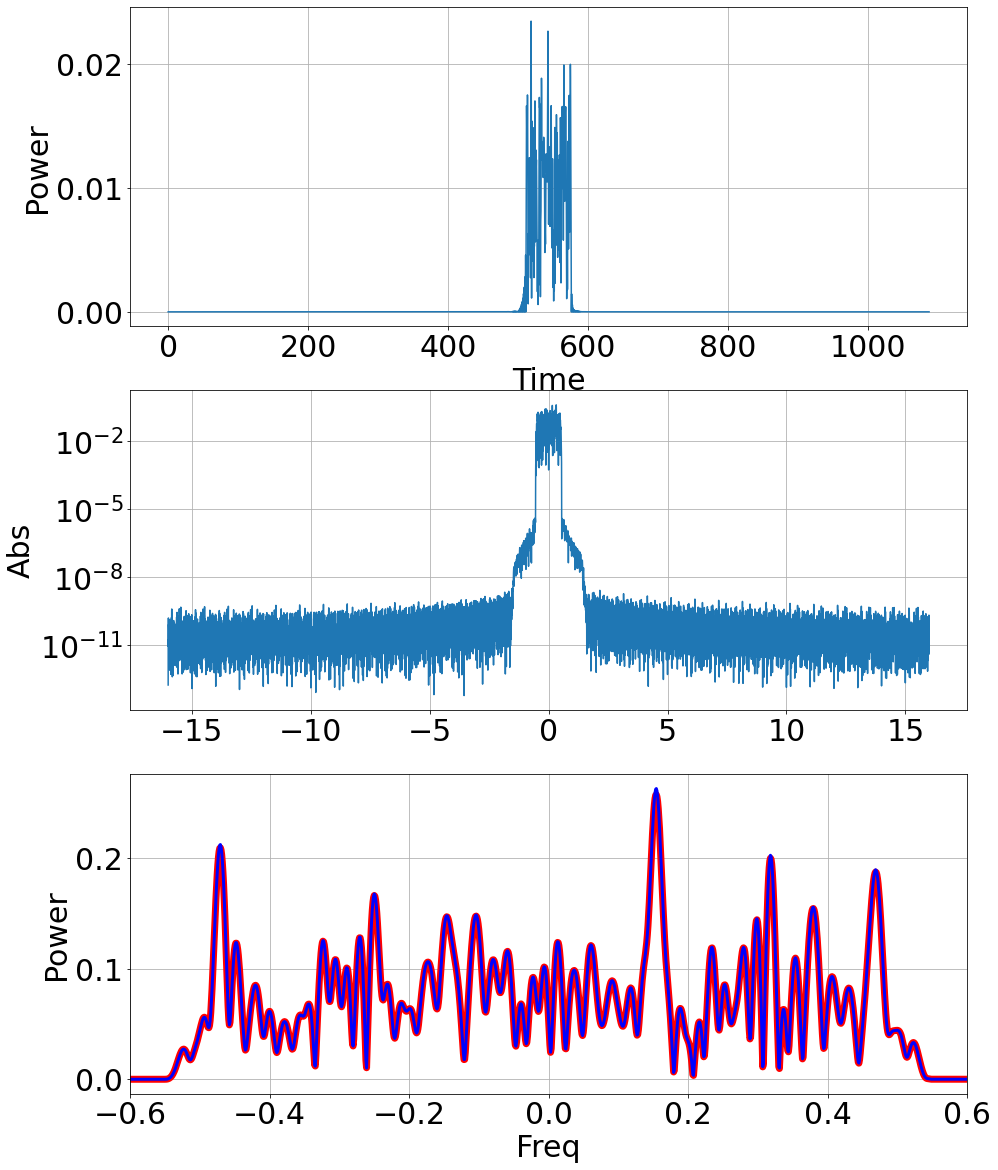

In [55]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(3, 1, figsize=(15, 20))
axs[0].plot(plt_t, np.absolute(plt_signal))
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(plt_f, abs(plt_ft_spectrum - plt_nft_spectrum))
# axs[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
# axs[1].set_xlim(-xi_span / 2, xi_span / 2)
# axs[1].set_xlabel('Xi')
axs[1].set_ylabel('Abs')
axs[1].set_yscale('log')
axs[1].grid(True)

axs[2].plot(plt_f, np.absolute(plt_ft_spectrum), 'red', lw=7)
axs[2].plot(plt_f, np.absolute(plt_nft_spectrum), 'blue', lw=3)
axs[2].set_xlim(-0.6, 0.6)
# axs[2].set_ylim(0, 5)
axs[2].set_xlabel('Freq')
axs[2].set_ylabel('Power')
axs[2].grid(True)


fig.show()

<ipython-input-64-e579137a47a3>:36: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



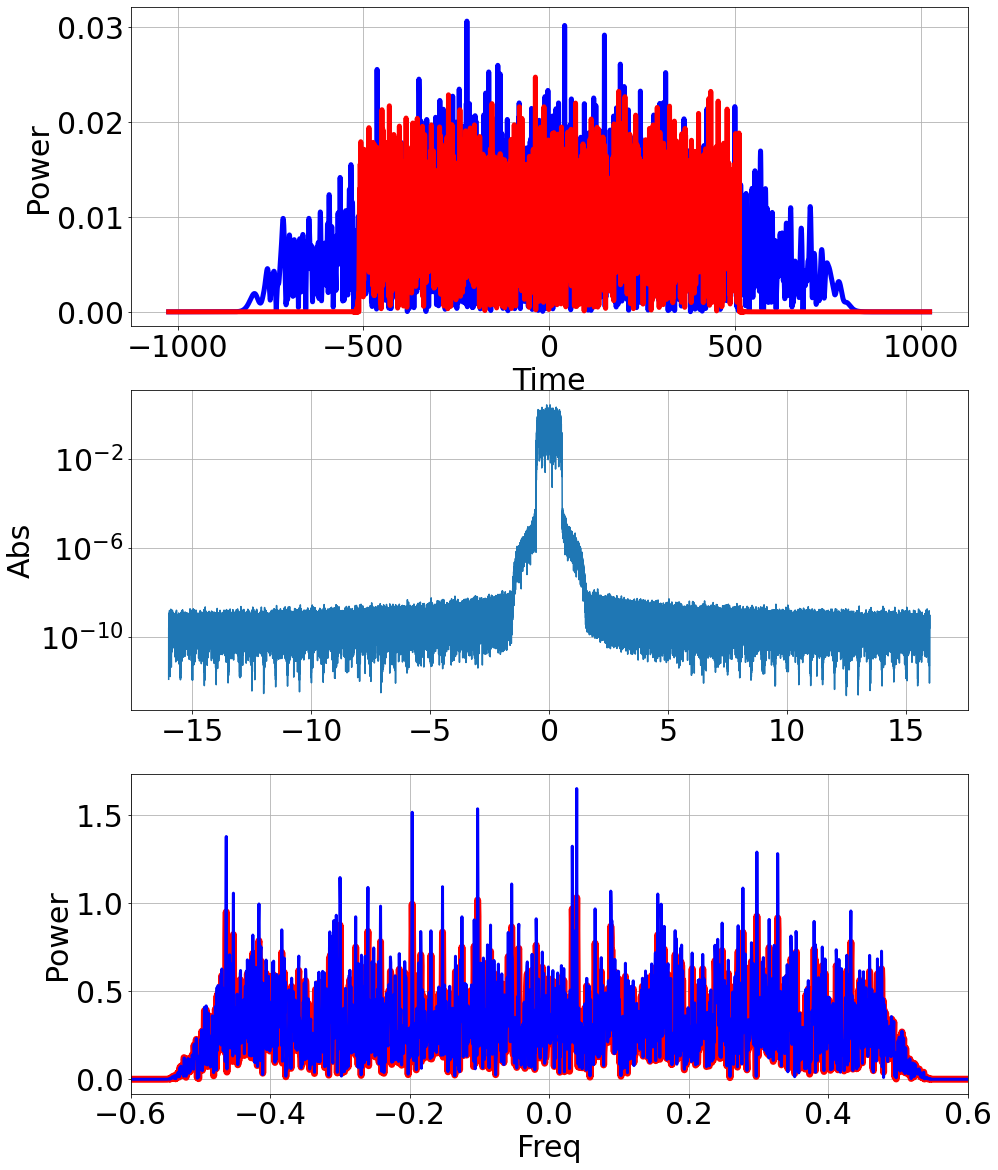

In [64]:
matplotlib.rcParams.update({'font.size': 30})

plt_signal = df_one.signal.item()
plt_ft_spectrum = df_one.ft_spec.item()
plt_nft_spectrum = df_one.result.item()['cont_ref']
plt_t = df_one.t.item()
plt_f = df_one.ft_f.item()
plt_xi = df_one.xi.item()
plt_dt = plt_t[1] - plt_t[0]

fig, axs = plt.subplots(3, 1, figsize=(15, 20))
axs[0].plot(plt_t - (plt_t[-1] - plt_t[0]) / 2., np.absolute(plt_signal_prop), 'blue', lw=5.0)
axs[0].plot(plt_t - (plt_t[-1] - plt_t[0]) / 2., np.absolute(plt_signal), 'red', lw=5.0)
# axs[0].set_xlim(plt_t[0], plt_t[-1])
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Power')
axs[0].grid(True)

axs[1].plot(plt_f, abs(plt_ft_spectrum_prop - plt_nft_spectrum_prop))
# axs[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
# axs[1].set_xlim(-xi_span / 2, xi_span / 2)
# axs[1].set_xlabel('Xi')
axs[1].set_ylabel('Abs')
axs[1].set_yscale('log')
axs[1].grid(True)

axs[2].plot(plt_f, np.absolute(plt_ft_spectrum_prop), 'red', lw=7)
axs[2].plot(plt_f, np.absolute(plt_nft_spectrum_prop), 'blue', lw=3)
axs[2].set_xlim(-0.6, 0.6)
# axs[2].set_ylim(0, 5)
axs[2].set_xlabel('Freq')
axs[2].set_ylabel('Power')
axs[2].grid(True)


fig.show()


## Main graphs

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'font.size': 40})


# tex style to regular
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
# matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

# regular to tex style
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


In [84]:
# t_span = 1.0
# n_span = 1024
# dt = t_span / n_span
# t = (np.arange(0, n_span) - n_span / 2) * dt
# dxi = np.pi / (2 * dt) / n_span
# xi = (np.arange(0, n_span) - n_span / 2) * dxi

t_s_dim = 14.8
f_dim = 1000 / 14.8 / (2 * np.pi)
e_dim_coef = 21.5 / (1.27 * 10**(-3) * t_s_dim)
p_dim_coef = (1 / t_s_dim * 21.5 / (1.27 * 10**(-3) * t_s_dim))

In [ ]:
def plot_and_save(x, y, x_func, y_func, colors, labels, x_label, y_label, file_name,
                  log_scale = False):
    fig = plt.figure(figsize=(16,7))
    ax = fig.add_subplot(111)
    for i in range(len(x)):
        if len(labels) == 0:
            ax.plot(x_func(x[i]), y_func(y[i]), color=colors[i], linewidth=4.0)
        else:
            ax.plot(x_func(x[i]), y_func(y[i]), label=labels[i], color=colors[i], linewidth=4.0)
    if log_scale:
        ax.set_yscale('log')
    # ax.set_title('')
    # ax.set_xlim(-0.5, 0.5)
    # ax.set_ylim(-0.2, 17)
    ax.set_ylabel(y_label, fontsize=42)
    ax.set_xlabel(x_label, fontsize=42)
    ax.grid()

    if len(labels) == 0:
        plt.legend(loc='upper left')
    # plt.tight_layout()
    plt.show()
    fig.savefig('images_nft_examples/' + file_name + '.pdf', format='pdf', bbox_inches='tight')

0.000129
0.001294
0.004092
0.012939


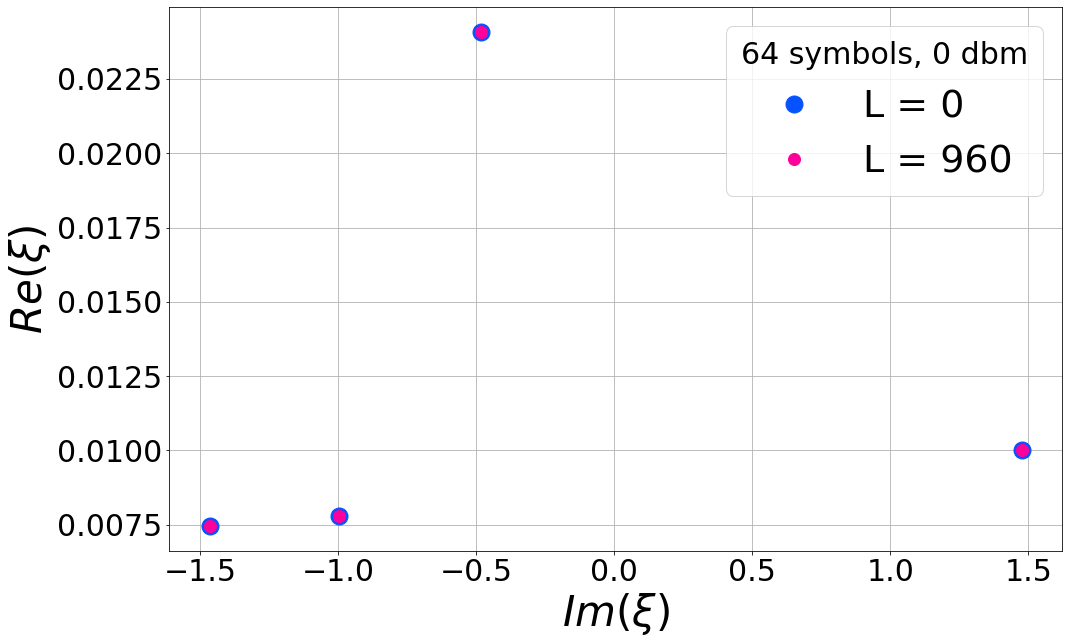

0.016289


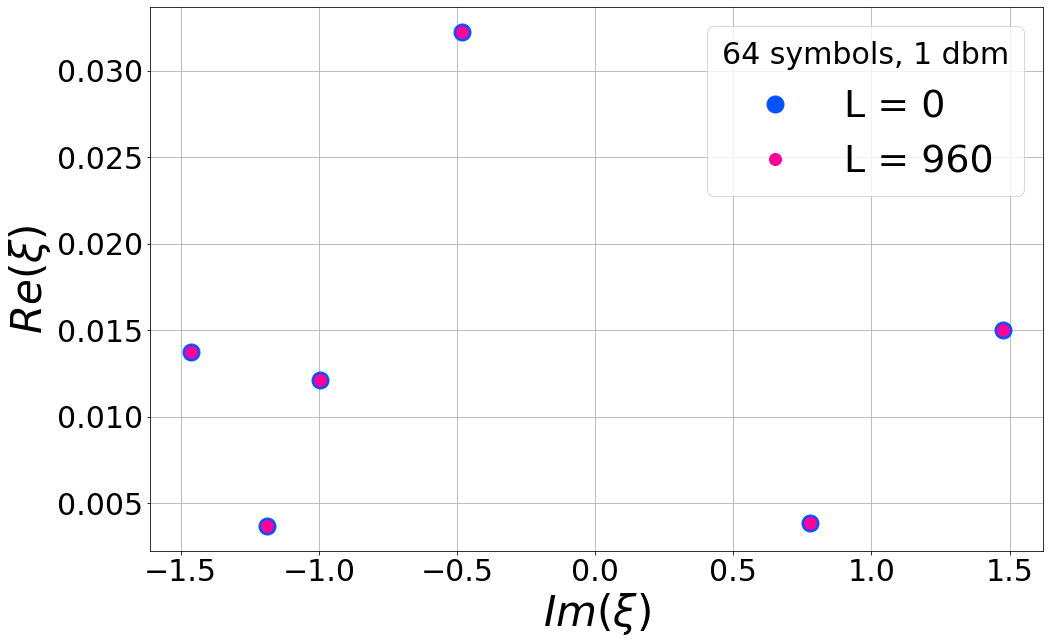

0.025816


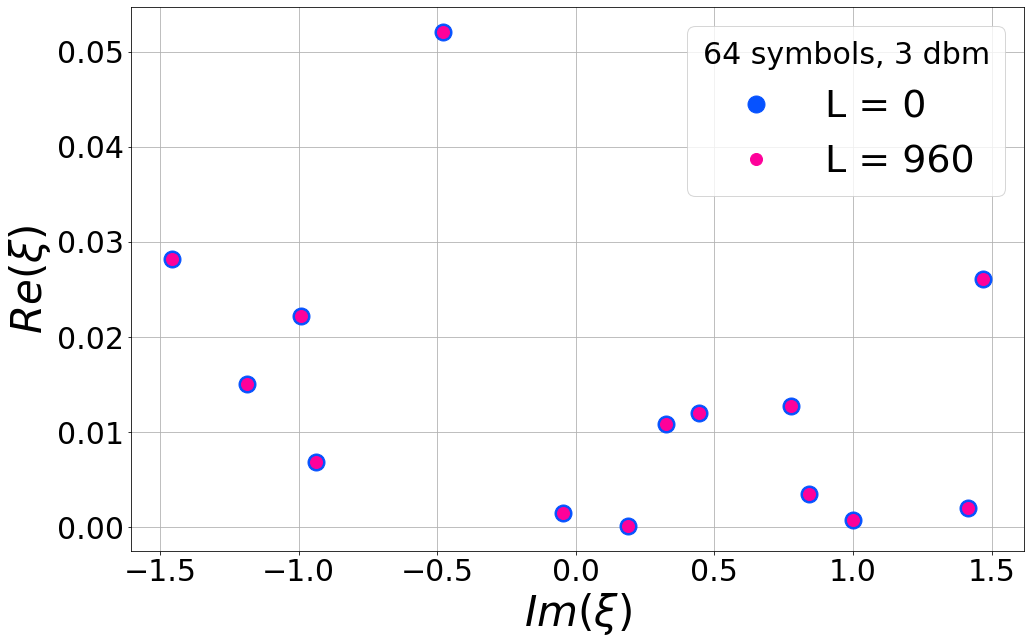

0.000129
0.001294
0.004092


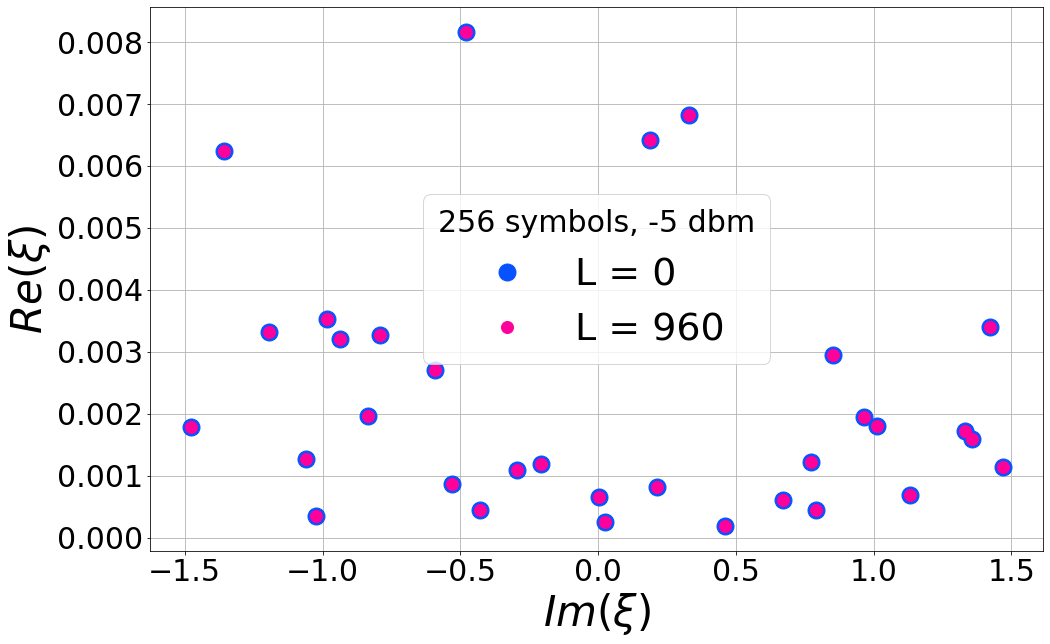

0.012939


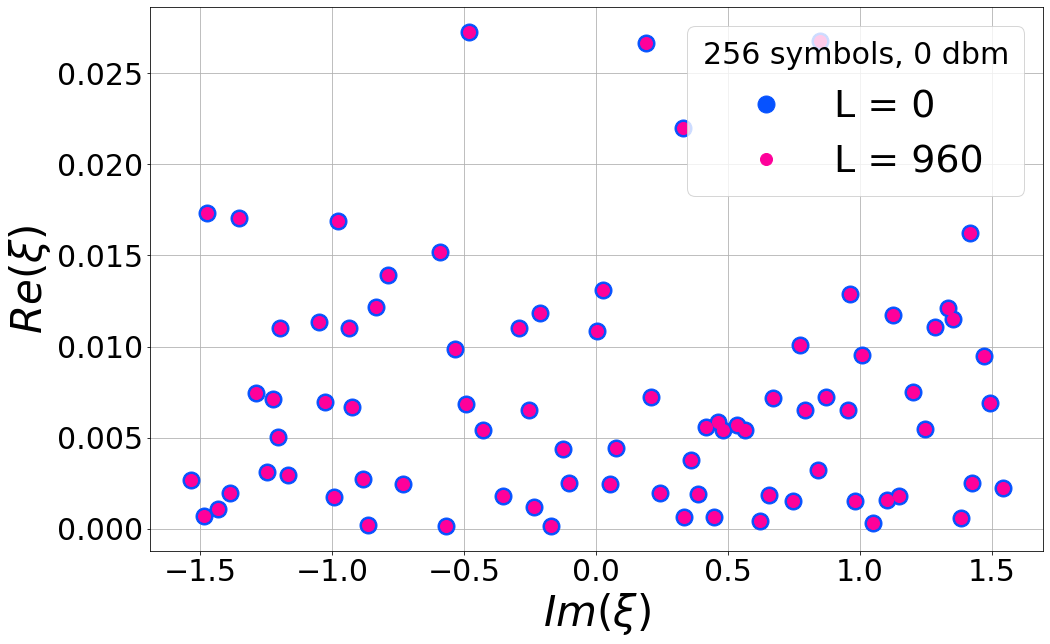

0.016289


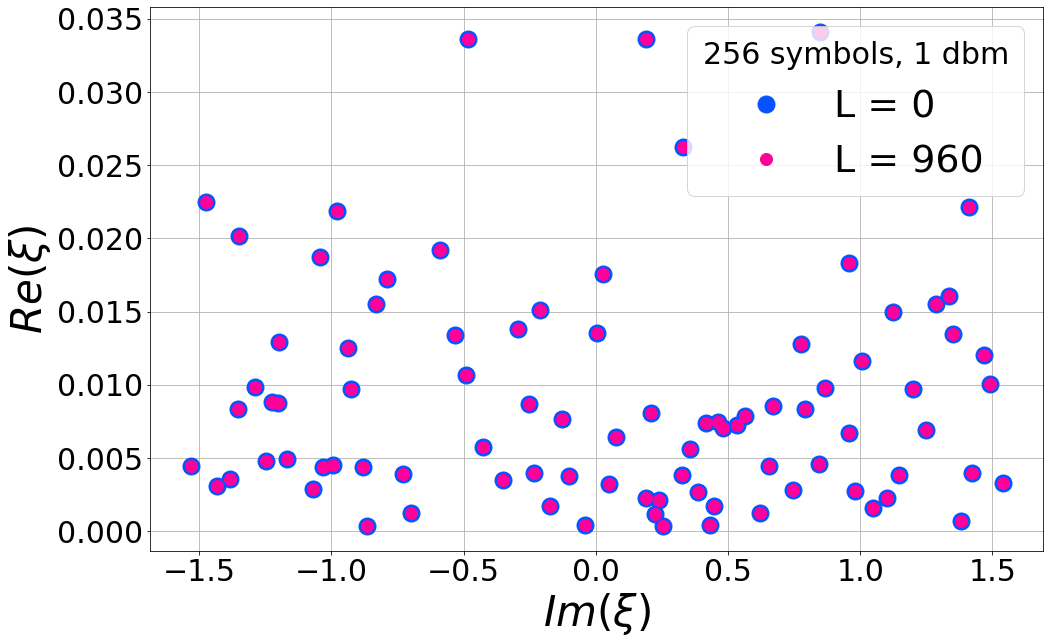

0.025816


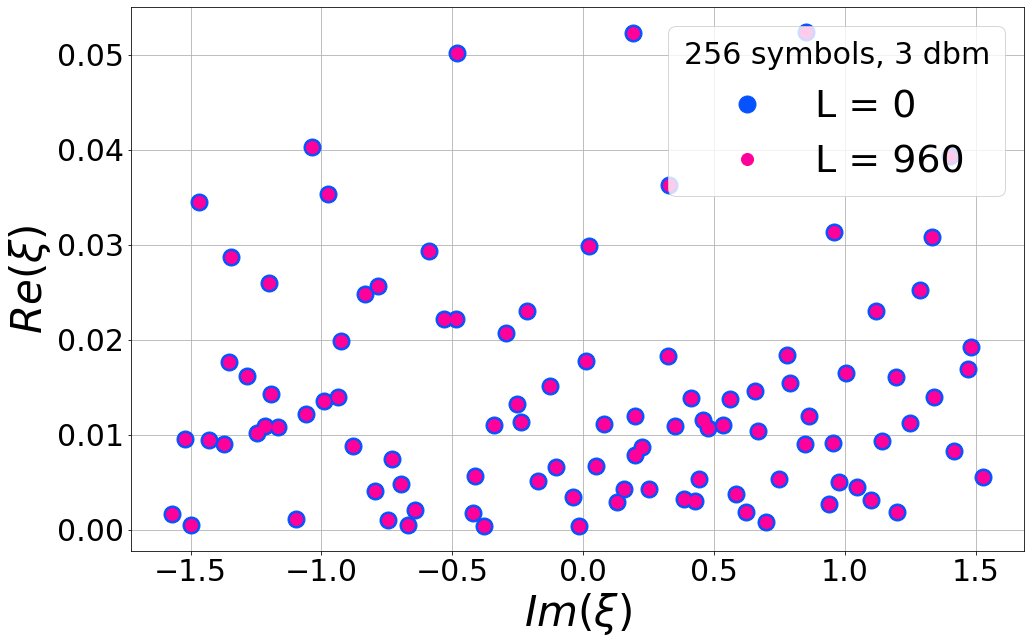

0.000129
0.001294


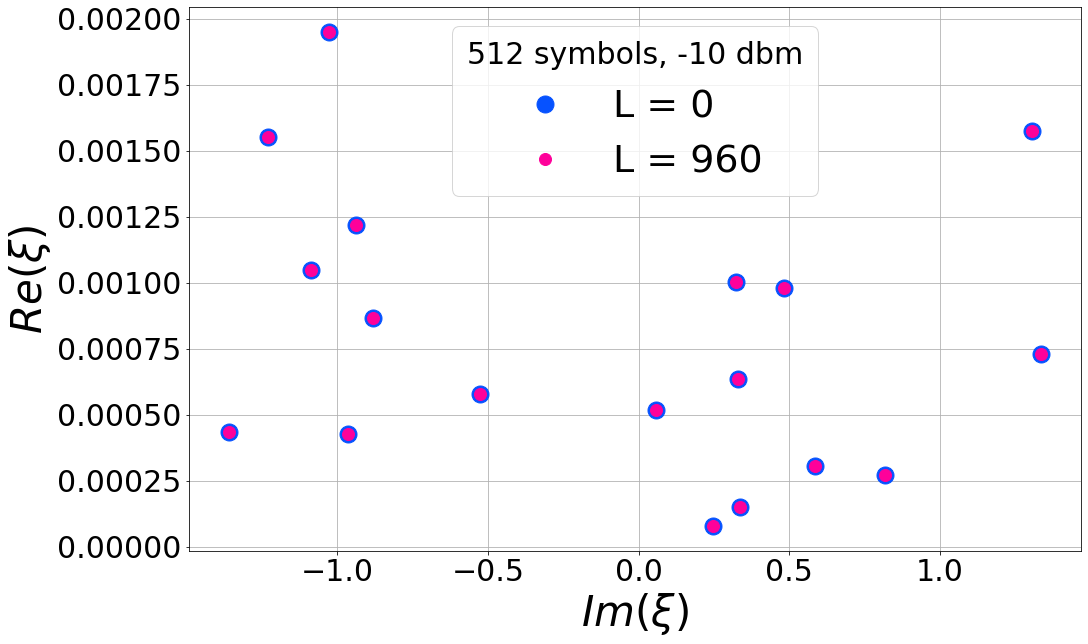

0.004092


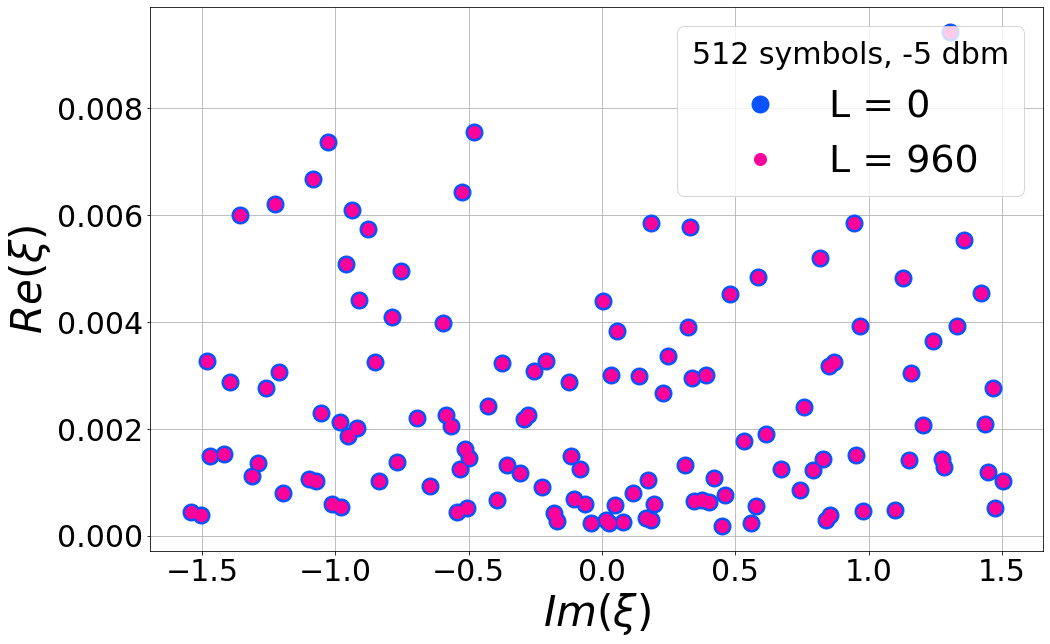

0.012939


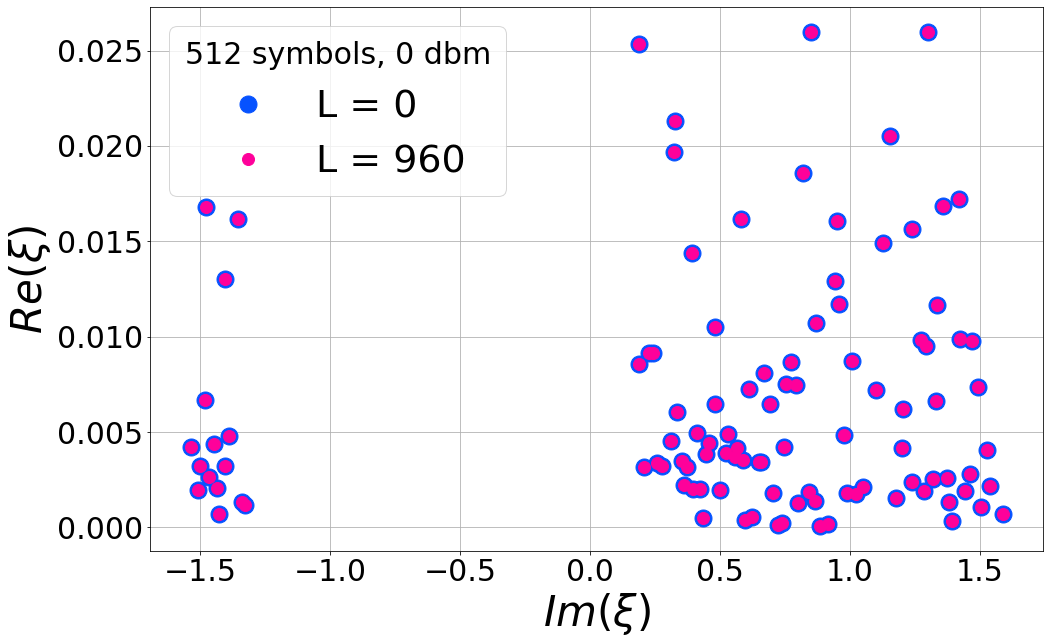

0.016289


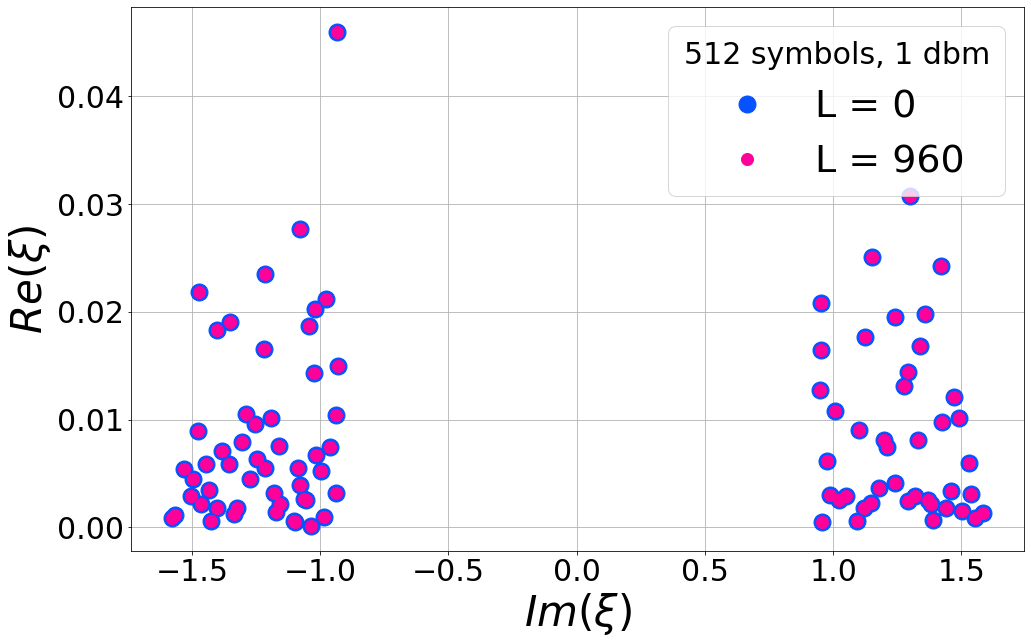

0.025816


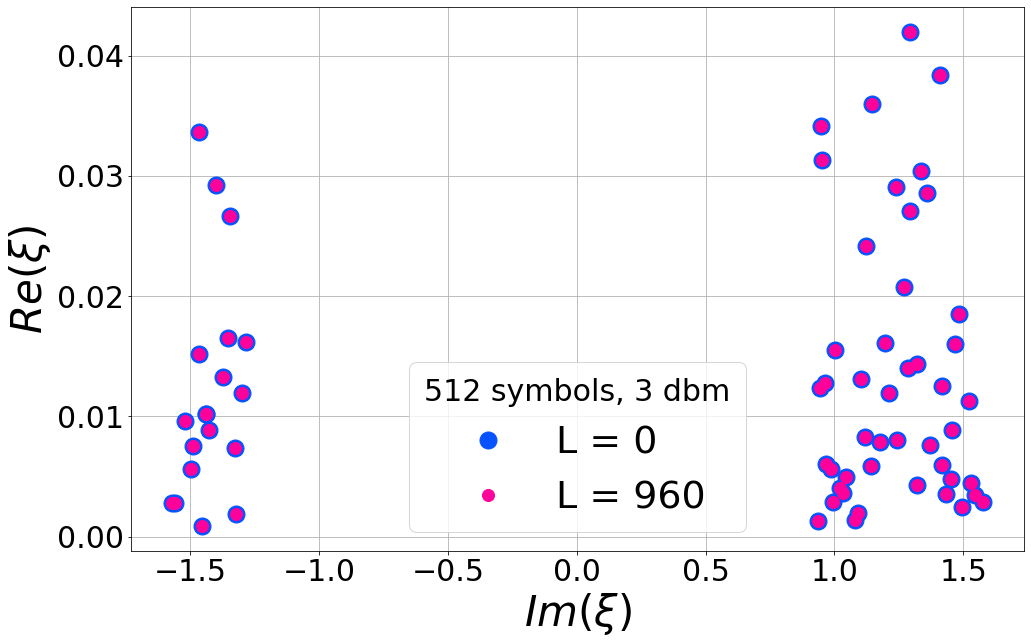

0.000129
0.001294


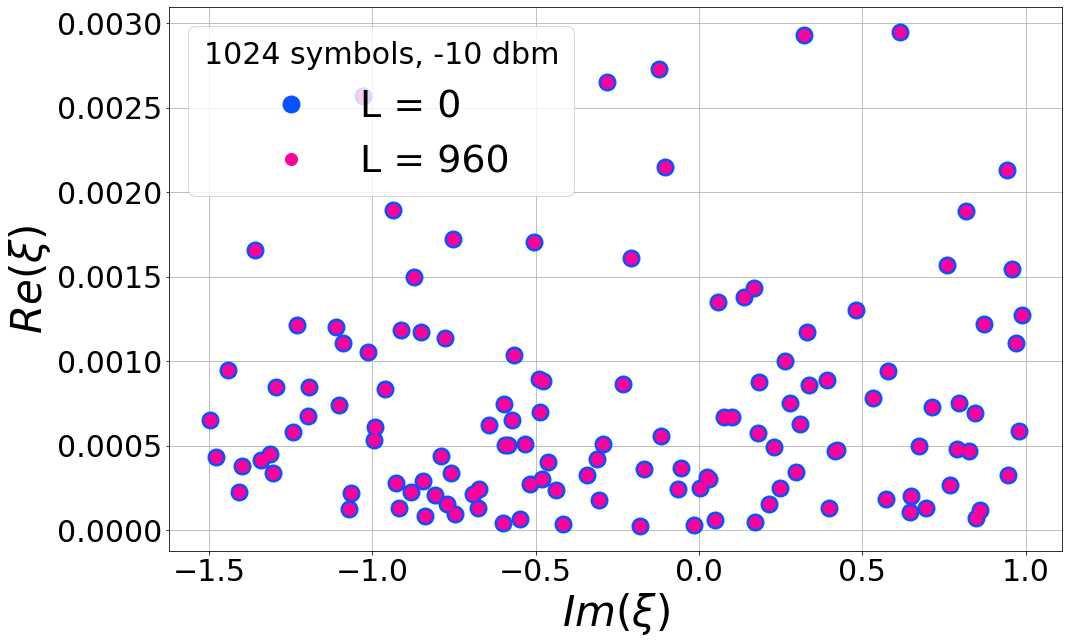

0.004092


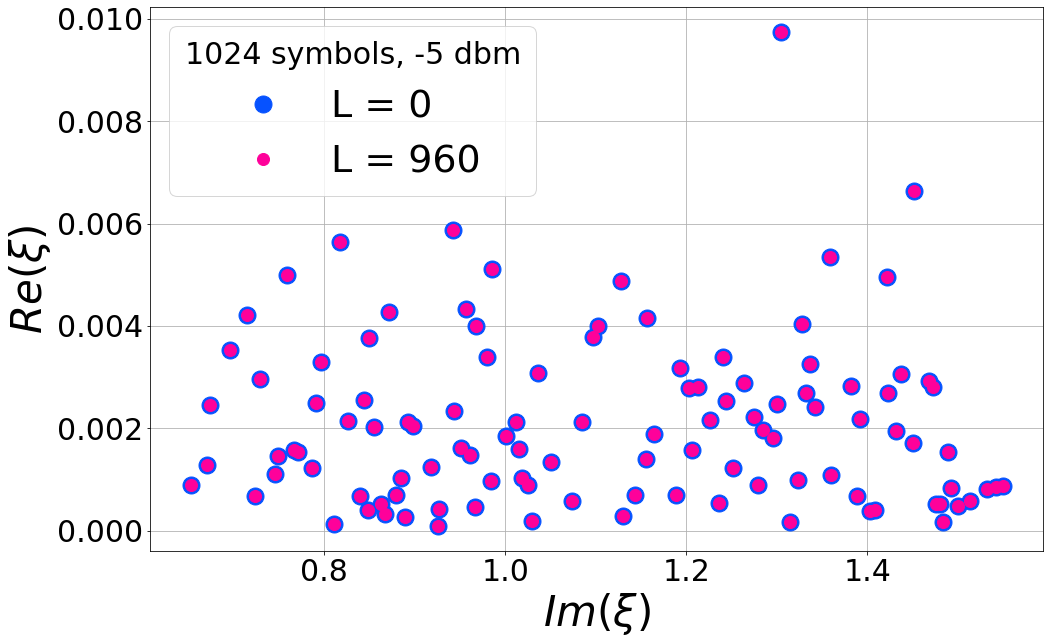

0.012939


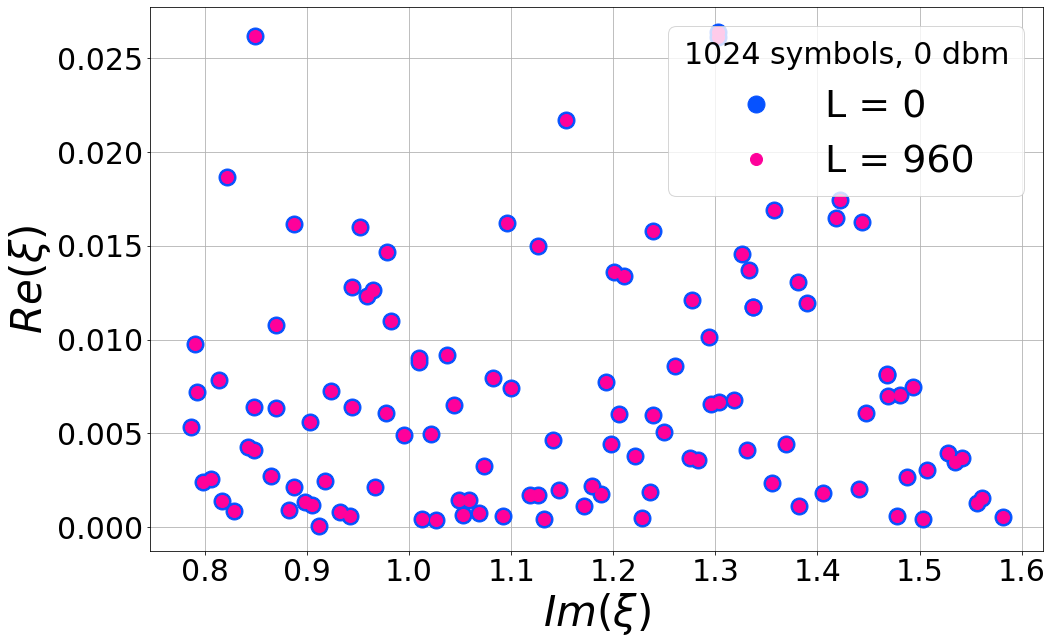

0.016289
0.025816


In [147]:
p_dbm_plot = [-20, -10, -5, 0, 1, 3]
for num_sy in [64, 256, 512, 1024]:
    for i_power in range(len(p_dbm_plot)):

# for num_sy in [512]:
#     for i_power in range(1,2):
        print(p_nd[i_power])

        df_one = df[(df.num_symbols == num_sy) & (df.p_ave == p_nd[i_power]) & (df.n_lateral == 512 * 32)]
        plt_signal = df_one.signal.item()
        plt_ft_spectrum = df_one.ft_spec.item()
        plt_nft_spectrum = df_one.result.item()['cont_ref']
        plt_nft_spectrum_discr = df_one.result.item()['bound_states']
        plt_t = df_one.t.item()
        plt_f = df_one.ft_f.item()
        plt_xi = df_one.xi.item()
        plt_dt = plt_t[1] - plt_t[0]

        plt_signal_prop = df_one.signal_prop.item()
        plt_ft_spectrum_prop = df_one.ft_spec_prop.item()
        plt_nft_spectrum_prop = df_one.res_prop.item()['cont_ref']
        plt_nft_spectrum_discr_prop = df_one.result.item()['bound_states']

        if len(plt_nft_spectrum_discr) == 0:
            continue

        # Signals
        # fig = plt.figure(figsize=(16,10))
        # ax = fig.add_subplot(111)
        # ax.plot(plt_t * t_s_dim - 2500, np.power(np.absolute(plt_signal_prop), 2) * p_dim_coef, color='red',
        #         label="L = 960 km",
        #         linewidth=4.0)
        # ax.plot(plt_t * t_s_dim - 2500, np.power(np.absolute(plt_signal), 2) * p_dim_coef, color='blue',
        #         label="L = 0 km",
        #         linewidth=4.0)
        # # ax.set_yscale('log')
        # # ax.set_title('')
        # ax.set_xlim(0, plt_t[-1] * t_s_dim - 5000)
        # # ax.set_ylim(-0.2, 17)
        # ax.set_ylabel(r'Power $P(t)$, mW', fontsize=42)
        # ax.set_xlabel(r'Time $t$, ps', fontsize=42)
        # ax.grid()
        #
        # plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # # plt.tight_layout()
        # plt.show()
        # fig.savefig('images_nft_examples/' + 'signal_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')

        # Spectrums
        # fig = plt.figure(figsize=(16,10))
        # ax = fig.add_subplot(111)
        # ax.plot(plt_xi, np.absolute(plt_nft_spectrum), color='xkcd:electric blue',
        #         # label="L = 0 km",
        #         linewidth=4.0)
        # # ax.plot(plt_xi, np.absolute(plt_nft_spectrum_prop), color='blue',
        # #         label="L = 960 km",
        # #         linewidth=4.0)
        # # ax.set_yscale('log')
        # # ax.set_title('')
        # ax.set_xlim(-2.5, 2.5)
        # # ax.set_ylim(-0.2, 17)
        # ax.set_ylabel(r'Continuous spectrum $|r(t)|$', fontsize=42)
        # ax.set_xlabel(r'Spectral parameter $\xi$', fontsize=42)
        # ax.grid()
        #
        # plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # # plt.tight_layout()
        # plt.show()
        # fig.savefig('images_nft_examples/' + 'nft_spectrum_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')
        #
        # fig = plt.figure(figsize=(16,10))
        # ax = fig.add_subplot(111)
        # ax.plot((plt_f + plt_f[0])* f_dim , np.absolute(plt_ft_spectrum) / np.max(np.absolute(plt_ft_spectrum)),
        #         color='xkcd:electric blue',
        #         # label="L = 0 km",
        #         linewidth=4.0)
        # # ax.plot((plt_f + plt_f[0]) * f_dim, np.absolute(plt_ft_spectrum_prop) / np.max(np.absolute(plt_ft_spectrum_prop)), color='xkcd:neon pink',
        # #         label="L = 960 km",
        # #         linewidth=4.0)
        # # ax.set_yscale('log')
        # # ax.set_title('')
        # ax.set_xlim(165, 180)
        # # ax.set_ylim(-0.2, 17)
        # ax.set_ylabel(r'Normalised Fourier spectrum $|s(f)|$', fontsize=36)
        # ax.set_xlabel(r'Frequency $f$, GHz', fontsize=42)
        # ax.grid()
        #
        # plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # # plt.tight_layout()
        # plt.show()
        # fig.savefig('images_nft_examples/' + 'ft_spectrum_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')
        #
        # fig = plt.figure(figsize=(16,10))
        # ax = fig.add_subplot(111)
        # ax.plot((plt_f + plt_f[0])* f_dim , np.absolute(plt_ft_spectrum) / np.max(np.absolute(plt_ft_spectrum)),
        #         color='xkcd:electric blue',
        #         label="L = 0 km",
        #         linewidth=10.0)
        # ax.plot((plt_f + plt_f[0]) * f_dim, np.absolute(plt_ft_spectrum_prop) / np.max(np.absolute(plt_ft_spectrum_prop)), color='xkcd:neon pink',
        #         label="L = 960 km",
        #         linewidth=4.0)
        # # ax.set_yscale('log')
        # # ax.set_title('')
        # ax.set_xlim(165, 180)
        # # ax.set_ylim(-0.2, 17)
        # ax.set_ylabel(r'Normalised Fourier spectrum $|s(f)|$', fontsize=36)
        # ax.set_xlabel(r'Frequency $f$, GHz', fontsize=42)
        # ax.grid()
        #
        # plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # # plt.tight_layout()
        # plt.show()
        # fig.savefig('images_nft_examples/' + 'ft_spectrum_with_prop_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')
        #

        # fig = plt.figure(figsize=(16,10))
        # ax = fig.add_subplot(111)
        # ax.plot(plt_xi, np.absolute(plt_ft_spectrum), color='xkcd:neon pink',
        #         label="FT",
        #         linewidth=8.0)
        # ax.plot(plt_xi, np.absolute(plt_nft_spectrum), color='xkcd:electric blue',
        #         label="NFT",
        #         linewidth=4.0)
        # # ax.set_yscale('log')
        # # ax.set_title('')
        # ax.set_xlim(-2, 2)
        # # ax.set_ylim(-0.2, 17)
        # ax.set_ylabel(r'Spectrum amplitude', fontsize=42)
        # ax.set_xlabel(r'Spectral parameter $\xi$', fontsize=42)
        # ax.grid()
        #
        # plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # # plt.tight_layout()
        # plt.show()
        # fig.savefig('images_nft_examples/' + 'ft_and_nft_spectrum_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')
        #
        # fig = plt.figure(figsize=(16,10))
        # ax = fig.add_subplot(111)
        # ax.plot(plt_xi, np.absolute(plt_ft_spectrum - plt_nft_spectrum), color='xkcd:electric blue',
        #         # label="FT",
        #         linewidth=5.0)
        # ax.set_yscale('log')
        # # ax.set_title('')
        # ax.set_xlim(-10, 10)
        # # ax.set_ylim(-0.2, 17)
        # ax.set_ylabel(r'Difference $|r(\xi) - r_{FT}(\xi)|$', fontsize=42)
        # ax.set_xlabel(r'Spectral parameter $\xi$', fontsize=42)
        # ax.grid()
        #
        # plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # # plt.tight_layout()
        # plt.show()
        # fig.savefig('images_nft_examples/' + 'ft_and_nft_diff_spectrum_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')

        # Discrete spectrum
        fig = plt.figure(figsize=(16,10))
        ax = fig.add_subplot(111)
        ax.plot(np.real(plt_nft_spectrum_discr), np.imag(plt_nft_spectrum_discr),
                color='xkcd:electric blue',
                marker='o',
                label="L = 0",
                linewidth=0, markersize=17)
        ax.plot(np.real(plt_nft_spectrum_discr_prop), np.imag(plt_nft_spectrum_discr_prop),
                color='xkcd:neon pink',
                marker='o',
                label="L = 960",
                linewidth=0, markersize=12)
        # ax.set_yscale('log')
        # ax.set_title('')
        # ax.set_xlim(-10, 10)
        # ax.set_ylim(-0.2, 17)
        ax.set_ylabel(r'$Re(\xi)$', fontsize=42)
        ax.set_xlabel(r'$Im(\xi)$', fontsize=42)
        ax.grid()

        plt.legend(title=str(num_sy) + ' symbols, ' + str(p_dbm_plot[i_power]) + ' dbm', loc='best', fontsize=38)
        # plt.tight_layout()
        plt.show()
        fig.savefig('images_nft_examples/' + 'discrete_nft_spectrum_nums' + str(num_sy) + '_' + str(i_power) + '.pdf', format='pdf', bbox_inches='tight')



# fig, axs = plt.subplots(3, 1, figsize=(15, 20))
# axs[0].plot(plt_t - (plt_t[-1] - plt_t[0]) / 2., np.absolute(plt_signal_prop), 'blue', lw=5.0)
# axs[0].plot(plt_t - (plt_t[-1] - plt_t[0]) / 2., np.absolute(plt_signal), 'red', lw=5.0)
# # axs[0].set_xlim(plt_t[0], plt_t[-1])
# axs[0].set_xlabel('Time')
# axs[0].set_ylabel('Power')
# axs[0].grid(True)
#
# axs[1].plot(plt_f, abs(plt_ft_spectrum_prop - plt_nft_spectrum_prop))
# # axs[1].set_xlim(-np.pi / t_span * nt / (2 * np.pi), np.pi / t_span * nt / (2 * np.pi))
# # axs[1].set_xlim(-xi_span / 2, xi_span / 2)
# # axs[1].set_xlabel('Xi')
# axs[1].set_ylabel('Abs')
# axs[1].set_yscale('log')
# axs[1].grid(True)
#
# axs[2].plot(plt_f, np.absolute(plt_ft_spectrum_prop), 'red', lw=7)
# axs[2].plot(plt_f, np.absolute(plt_nft_spectrum_prop), 'blue', lw=3)
# axs[2].set_xlim(-0.6, 0.6)
# # axs[2].set_ylim(0, 5)
# axs[2].set_xlabel('Freq')
# axs[2].set_ylabel('Power')
# axs[2].grid(True)



Here I load signal from Igor and check it with my own

In [19]:
def read_csv(file, delimiter=' '):
    # max_lines = 10
    data = []
    # i = 0
    for row in csv.reader(file, delimiter=delimiter):
        # print(row)
        data.append(row)
        # i += 1
        # if i >= max_lines:
        #     break
    return data

signal_file_name = "../data/signal_from_igor/signal.dat"
points_file_name = "../data/signal_from_igor/symbols.dat"

['-3.038576e-08', '0.000000e+00', ' 0.000000e+00', ' 0.000000e+00', '']


In [ ]:
with open(signal_file_name, "r") as csv_file:
    signal_data = read_csv(csv_file, '\t')

In [32]:
with open(points_file_name, "r") as csv_file:
    points_data = read_csv(csv_file, '\t')


['-1.34164', '-1.34164']


In [33]:
n_span = len(signal_data)
t = np.zeros(n_span)
q = np.zeros(n_span, dtype=complex)

for i in range(n_span):
    t[i] = float(signal_data[i][0])
    q[i] = complex(float(signal_data[i][1]), float(signal_data[i][2]))

n_points = len(points_data)
points = np.zeros(n_points, dtype=complex)

for i in range(n_points):
    points[i] = complex(float(points_data[i][0]), float(points_data[i][1]))





Form my signal with Igor's points

In [66]:
roll_off = 0.1
t_symb = 1.0
n_symb = 16
dt = t_symb / n_symb
n_car = 1
n_lat = 16 * n_symb
wdm_signal_orig = sg.get_wdm_signal_by_points(points, t_symb, n_symb,
                                         func=sg.srrcos, func_args=[t_symb, roll_off],
                                         n_carriers=n_car, n_lateral=n_lat)

In [117]:
p_db = -50
p_nd = sg.mw_to_nd(sg.dbm_to_mw(p_db))
wdm_signal = sg.set_average_power(wdm_signal_orig, dt, p_nd)
print(p_nd, sg.get_average_power(wdm_signal, dt))

# n_lat_zero = (2**17 - len(wdm_signal)) // 2
n_lat_zero = 2**14
wdm_signal = sg.add_lateral(wdm_signal, n_lat_zero)

print(len(wdm_signal), len(q))
dt_my = 1. / len(wdm_signal)
t_my = np.array([i * dt_my for i in range(len(wdm_signal))])

dt_igor = 1. / len(q)
t_igor = np.array([i * dt_igor for i in range(len(q))])

5.906976744186046e-06 5.906976744186045e-06
66048 131072


<ipython-input-119-c58ea9bb1562>:11: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



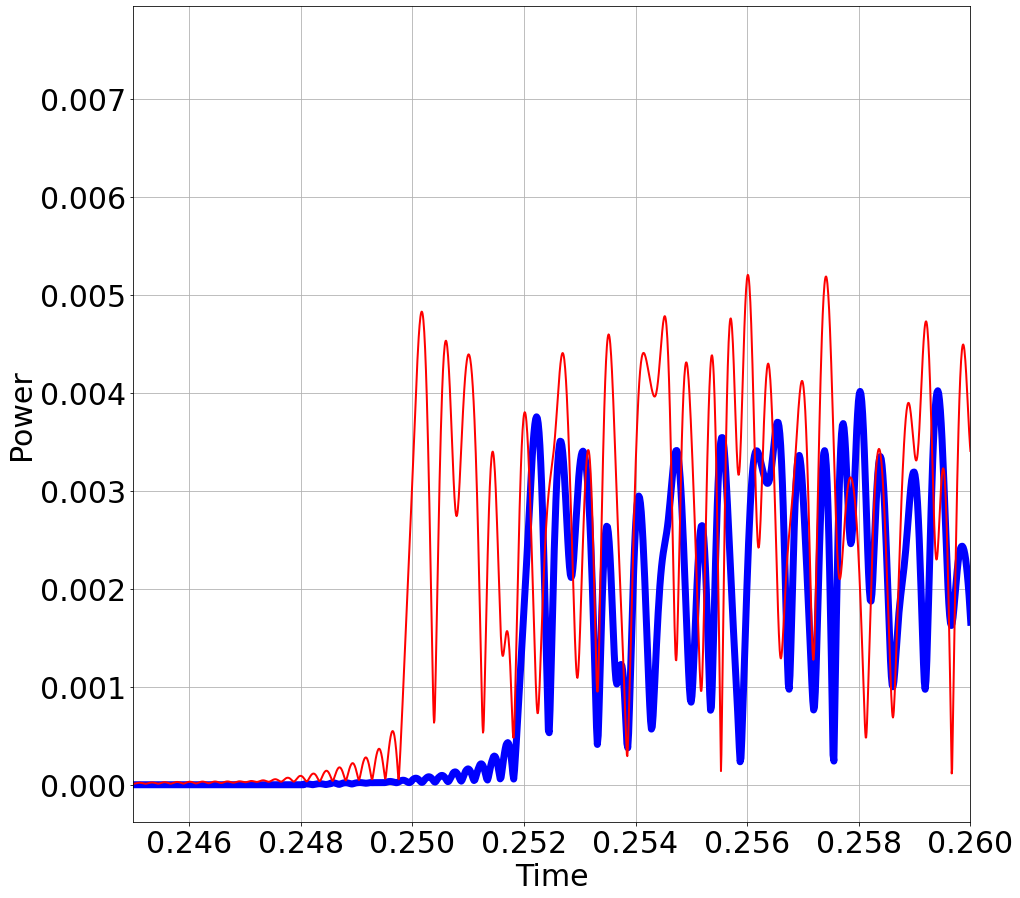

In [119]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(t_my, np.absolute(wdm_signal), 'blue', linewidth=7)
axs.plot(t_igor, np.absolute(q), 'red', linewidth=2)
axs.set_xlim(0.245, 0.26)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

fig.show()

<ipython-input-43-5a3f4545b2fe>:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



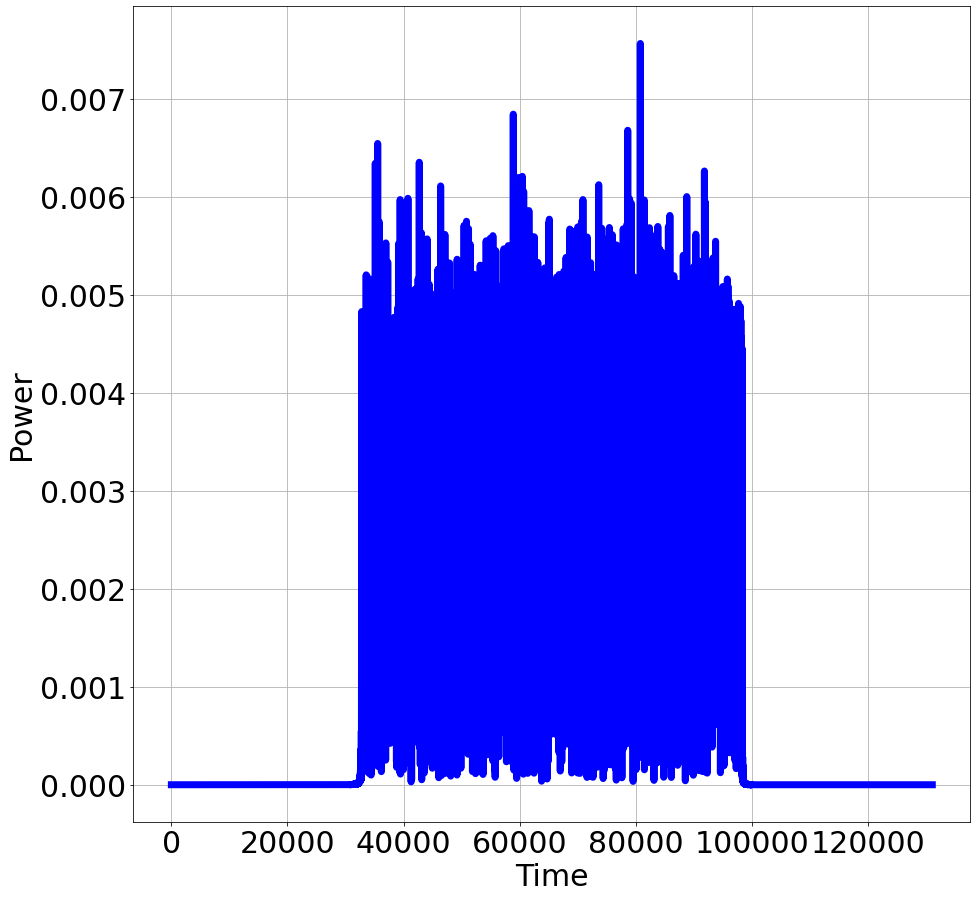

In [43]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(np.absolute(q), 'blue', linewidth=7)
# axs.set_xlim(40000, 45000)
axs.set_xlabel('Time')
axs.set_ylabel('Power')
axs.grid(True)

fig.show()

<ipython-input-38-298a80bbbed7>:10: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



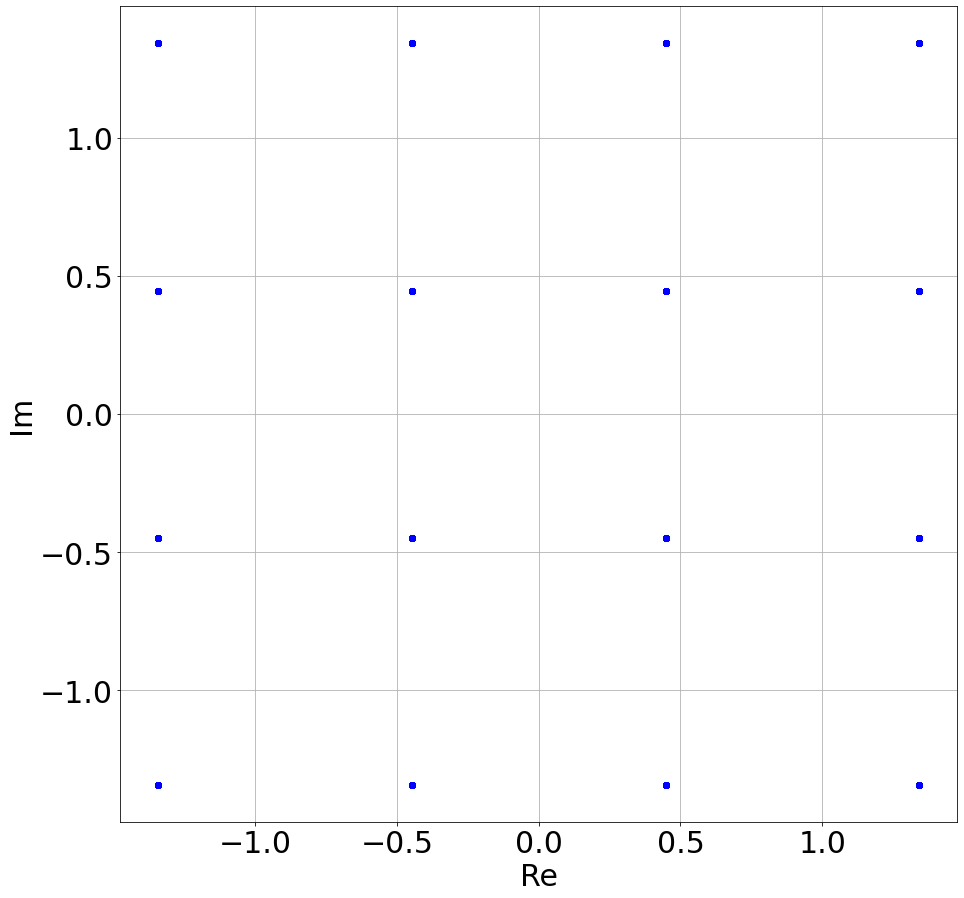

In [38]:
matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(1, 1, figsize=(15,15))
axs.plot(np.real(points), np.imag(points), 'blue', linestyle='', marker='o')
# axs.set_xlim(40000, 45000)
axs.set_xlabel('Re')
axs.set_ylabel('Im')
axs.grid(True)

fig.show()